## Link Video
### https://drive.google.com/drive/folders/1v1En2xqdBHOVpnJODKBRemMxlZTXfk8y?usp=sharing

# **3. Data Generation using GAN (Modified Model)**

## Import Library

In [1]:
from zipfile import ZipFile
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, Conv2DTranspose, Activation, LeakyReLU, Flatten, MaxPooling2D, UpSampling2D, Cropping2D, BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import array_to_img
from scipy.linalg import sqrtm

## Extract File (Because In Colab)

In [2]:
zip_path = '/content/B_23.zip'
extract_path = '/content/B_23'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

def loadFile(folder_path='/content/B_23', size=(100, 100)):
    images = []
    valid_extensions = ('.jpg', '.png', '.jpeg')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(valid_extensions):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 127.5 - 1.0
            images.append(img)

    return np.array(images)

real_images = loadFile()
print("Images loaded:", real_images.shape)

Images loaded: (0,)


## Read Data

In [3]:
def loadFile(folder_path='B_23', size=(100, 100)):
    images = []
    valid_extensions = ('.jpg', '.png', '.jpeg')

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(valid_extensions):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 127.5 - 1.0
            images.append(img)

    return np.array(images)

In [4]:
real_images = loadFile('B_23/B_23', size=(100, 100))

## Show Image

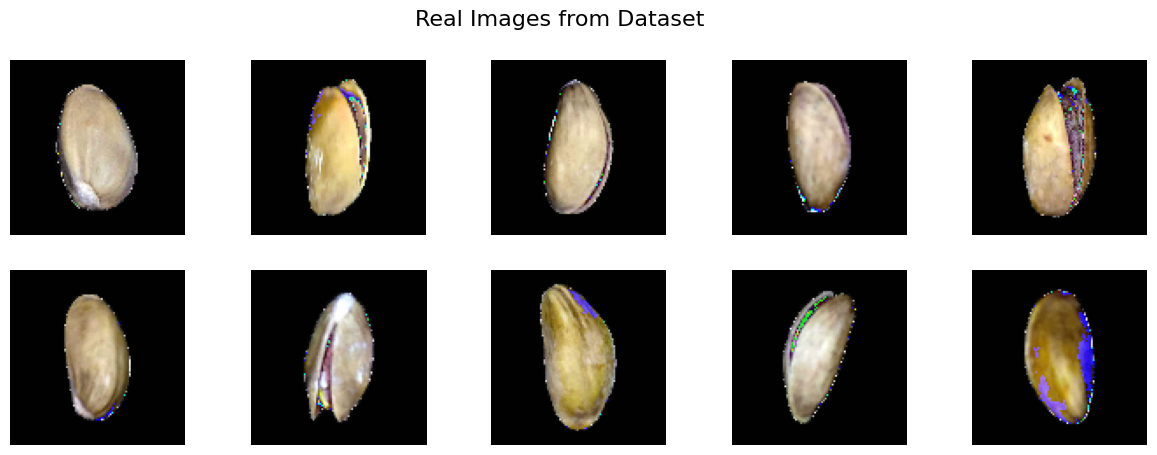

In [5]:
def plot_real_images(images, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow((images[i] * 255).astype(np.uint8))
        plt.axis('off')
    plt.suptitle('Real Images from Dataset', fontsize=16)
    plt.show()

plot_real_images(real_images, num_images=10)

## Generator Model

In [6]:
def build_generator(noise_dim=100):
    model = Sequential()

    model.add(Dense(25 * 25 * 128, input_dim=noise_dim))
    model.add(Reshape((25, 25, 128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(32, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

    return model

modification ReLu into LeakyReLU gives smoother gradients, then the padding we change into 'same' give spatial size consistent, batchnormalization helps stabilize training, and changging the architecture into 25 x 25 x 128 and upsamples to match size of 100 x 100 more cleanly and efficiently

## Discriminator Model

In [7]:
def build_discriminator(input_shape=(100, 100, 3)):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=input_shape))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

changging the ReLU with LeakyReLU same like generator, then adding dropout to prevent discriminator from overfitting, then strides into 2 for learnable weights with padding change into 'same' to maintains spatial shape better during conv layers, then changging the channels into 64 -> 128 -> 256 for more powerful discriminator to handle higher resolution images

In [8]:
class CustomGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.disc = discriminator
        self.gen = generator
        self.latent_dim = latent_dim

    def compile(self, disc_optimizer, gen_optimizer, loss_function):
        super().compile()
        self.d_opt = disc_optimizer
        self.g_opt = gen_optimizer
        self.loss_fn = loss_function
        self.d_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")
        self.g_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")

    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        with tf.GradientTape() as tape:
            generated = self.gen(noise, training=True)
            real_pred = self.disc(real_data, training=True)
            fake_pred = self.disc(generated, training=True)

            real_labels = tf.ones_like(real_pred) * 0.9
            fake_labels = tf.zeros_like(fake_pred)

            d_loss_real = self.loss_fn(real_labels, real_pred)
            d_loss_fake = self.loss_fn(fake_labels, fake_pred)
            d_loss = d_loss_real + d_loss_fake
        disc_grads = tape.gradient(d_loss, self.disc.trainable_weights)
        self.d_opt.apply_gradients(zip(disc_grads, self.disc.trainable_weights))

        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            gen_imgs = self.gen(noise, training=True)
            disc_pred = self.disc(gen_imgs, training=True)
            g_loss = self.loss_fn(tf.ones_like(disc_pred), disc_pred)

        gen_grads = tape.gradient(g_loss, self.gen.trainable_weights)
        self.g_opt.apply_gradients(zip(gen_grads, self.gen.trainable_weights))

        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {
            "disc_loss": self.d_loss_tracker.result(),
            "gen_loss": self.g_loss_tracker.result(),
        }

In [9]:
class GANSnapshotCallback(tf.keras.callbacks.Callback):
    def __init__(self, num_samples=5, latent_dim=100, save_every=10):
        super().__init__()
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.save_every = save_every
        self.fixed_noise = tf.random.normal([self.num_samples, self.latent_dim])

        self.g_losses = []
        self.d_losses = []

        self.output_dir = "epoch_generated_images"
        os.makedirs(self.output_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        self.d_losses.append(logs.get('d_loss'))
        self.g_losses.append(logs.get('g_loss'))

        if (epoch + 1) % self.save_every == 0:
            fake_images = self.model.gen(self.fixed_noise, training=False)
            fake_images = (fake_images + 1.0) / 2.0

            fig, axes = plt.subplots(1, self.num_samples, figsize=(15, 3))
            fig.suptitle(f"Generated Samples at Epoch {epoch + 1}", fontsize=14)

            for i in range(self.num_samples):
                axes[i].imshow(fake_images[i])
                axes[i].axis('off')

            plt.show()
            plt.close()

## Build Model

In [10]:
noise_dim = 100

generator = build_generator()
discriminator = build_discriminator()

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

gan = CustomGAN(discriminator, generator, latent_dim=noise_dim)
gan.compile(
    disc_optimizer=disc_optimizer,
    gen_optimizer=gen_optimizer,
    loss_function=tf.keras.losses.BinaryCrossentropy()
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Preprocess Image

In [11]:
real_images = loadFile('B_23/B_23', size=(100, 100))
print(real_images.shape)

(1074, 100, 100, 3)


Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - disc_loss: 0.9853 - gen_loss: 1.4723
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.3669 - gen_loss: 0.8260
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - disc_loss: 1.3617 - gen_loss: 0.8124
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.3552 - gen_loss: 0.8195
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.3510 - gen_loss: 0.8465
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.3497 - gen_loss: 0.8475
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 1.3504 - gen_loss: 0.8383
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.3490 - gen_loss: 0.8343
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.3562 - gen_loss: 0.8490
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.3594 - gen_loss: 0.8398
Epoch 11/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 

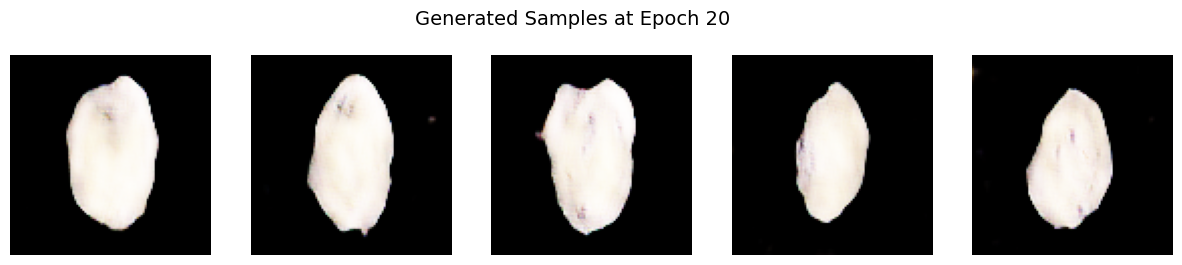

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - disc_loss: 1.3366 - gen_loss: 0.8540
Epoch 21/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 1.3336 - gen_loss: 0.8682
Epoch 22/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.3291 - gen_loss: 0.8661
Epoch 23/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 1.3396 - gen_loss: 0.8636
Epoch 24/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.3416 - gen_loss: 0.8784
Epoch 25/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.3275 - gen_loss: 0.8812
Epoch 26/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.3246 - gen_loss: 0.8712
Epoch 27/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.3330 - gen_loss: 0.8693
Epoch 28/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.3233 - gen_loss: 0.8750
Epoch 29/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.3224 - gen_loss: 0.8773
Epoch 30/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.333

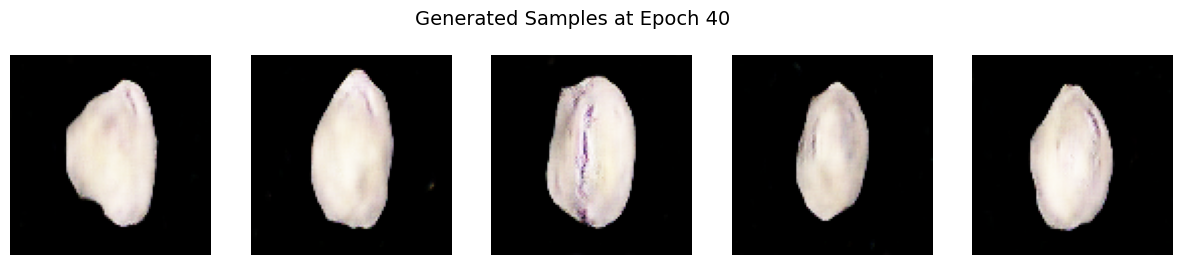

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 1.2915 - gen_loss: 0.9096
Epoch 41/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2866 - gen_loss: 0.9410
Epoch 42/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2855 - gen_loss: 0.9357
Epoch 43/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2890 - gen_loss: 0.9365
Epoch 44/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2670 - gen_loss: 0.9575
Epoch 45/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2721 - gen_loss: 0.9974
Epoch 46/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.2656 - gen_loss: 0.9619
Epoch 47/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2738 - gen_loss: 0.9475
Epoch 48/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.2605 - gen_loss: 0.9710
Epoch 49/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.2730 - gen_loss: 0.9726
Epoch 50/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 1.257

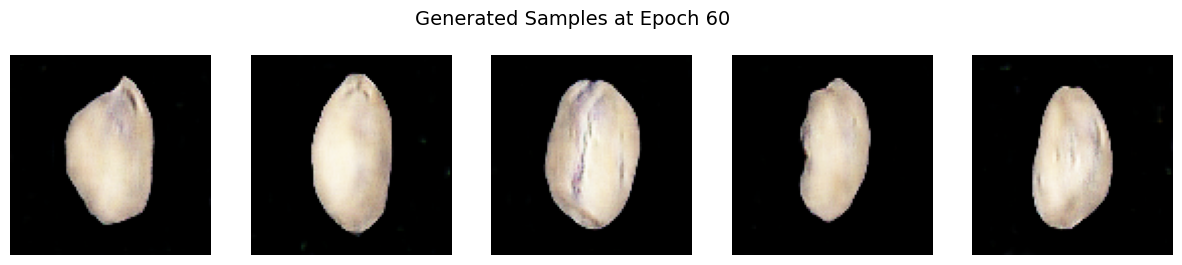

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 1.2358 - gen_loss: 1.0345
Epoch 61/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.2392 - gen_loss: 1.0246
Epoch 62/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2655 - gen_loss: 1.0151
Epoch 63/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2446 - gen_loss: 0.9974
Epoch 64/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2423 - gen_loss: 1.0662
Epoch 65/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - disc_loss: 1.2288 - gen_loss: 1.0470
Epoch 66/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - disc_loss: 1.2256 - gen_loss: 1.0470
Epoch 67/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2436 - gen_loss: 1.0430
Epoch 68/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2106 - gen_loss: 1.0589
Epoch 69/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.2266 - gen_loss: 1.0268
Epoch 70/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.228

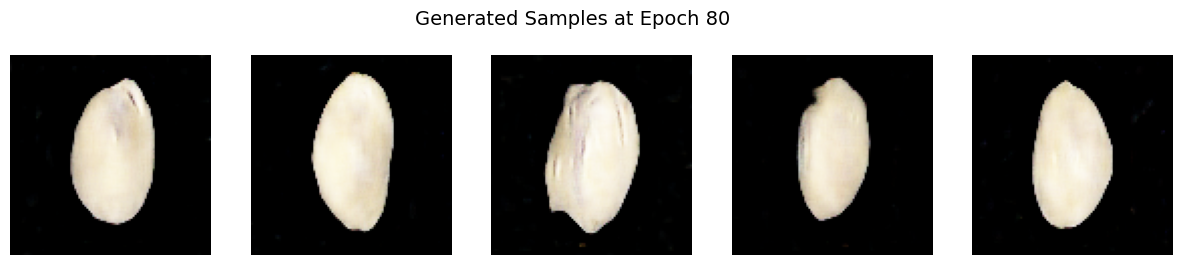

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - disc_loss: 1.2002 - gen_loss: 1.1074
Epoch 81/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - disc_loss: 1.1885 - gen_loss: 1.0824
Epoch 82/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - disc_loss: 1.1950 - gen_loss: 1.0879
Epoch 83/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.1836 - gen_loss: 1.0694
Epoch 84/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.1926 - gen_loss: 1.1281
Epoch 85/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1997 - gen_loss: 1.0873
Epoch 86/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 1.2107 - gen_loss: 1.0902
Epoch 87/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.1974 - gen_loss: 1.1137
Epoch 88/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1769 - gen_loss: 1.0730
Epoch 89/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.2069 - gen_loss: 1.0862
Epoch 90/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.197

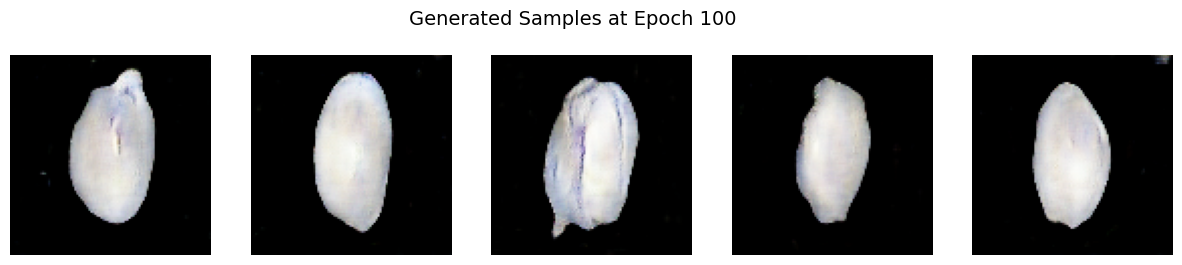

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 1.1453 - gen_loss: 1.1887
Epoch 101/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1510 - gen_loss: 1.1973
Epoch 102/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.1793 - gen_loss: 1.1885
Epoch 103/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1670 - gen_loss: 1.1225
Epoch 104/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.1551 - gen_loss: 1.1557
Epoch 105/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.1484 - gen_loss: 1.1297
Epoch 106/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1557 - gen_loss: 1.2020
Epoch 107/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1695 - gen_loss: 1.1966
Epoch 108/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1559 - gen_loss: 1.1527
Epoch 109/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1440 - gen_loss: 1.1972
Epoch 110/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_l

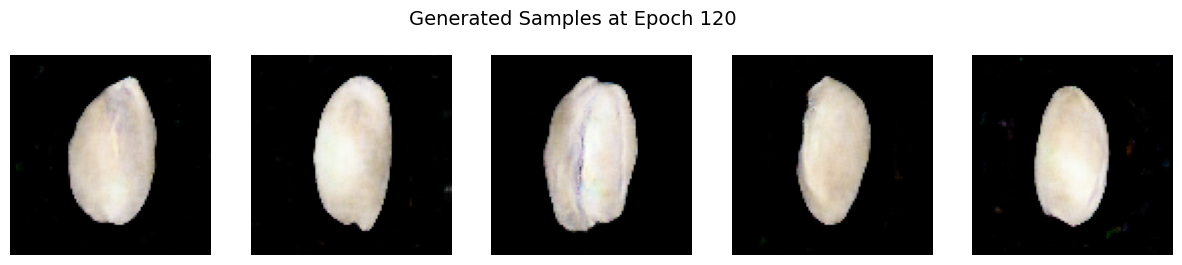

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 1.1267 - gen_loss: 1.2755
Epoch 121/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.1255 - gen_loss: 1.2182
Epoch 122/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 1.1180 - gen_loss: 1.2374
Epoch 123/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1289 - gen_loss: 1.1903
Epoch 124/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1002 - gen_loss: 1.2774
Epoch 125/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.1102 - gen_loss: 1.3338
Epoch 126/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1193 - gen_loss: 1.2348
Epoch 127/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1185 - gen_loss: 1.2653
Epoch 128/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1007 - gen_loss: 1.2469
Epoch 129/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1244 - gen_loss: 1.3050
Epoch 130/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_l

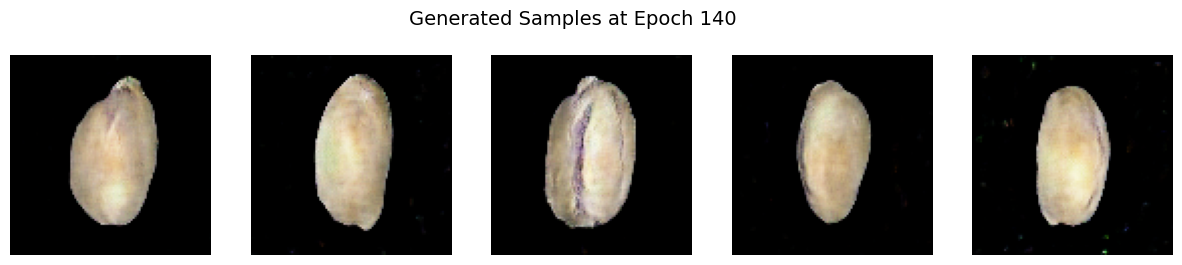

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 1.0815 - gen_loss: 1.3257
Epoch 141/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.1114 - gen_loss: 1.3151
Epoch 142/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0565 - gen_loss: 1.3170
Epoch 143/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.0815 - gen_loss: 1.3205
Epoch 144/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 1.0390 - gen_loss: 1.3295
Epoch 145/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.0683 - gen_loss: 1.3896
Epoch 146/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0833 - gen_loss: 1.3135
Epoch 147/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0637 - gen_loss: 1.3463
Epoch 148/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0696 - gen_loss: 1.3269
Epoch 149/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.0909 - gen_loss: 1.5885
Epoch 150/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_l

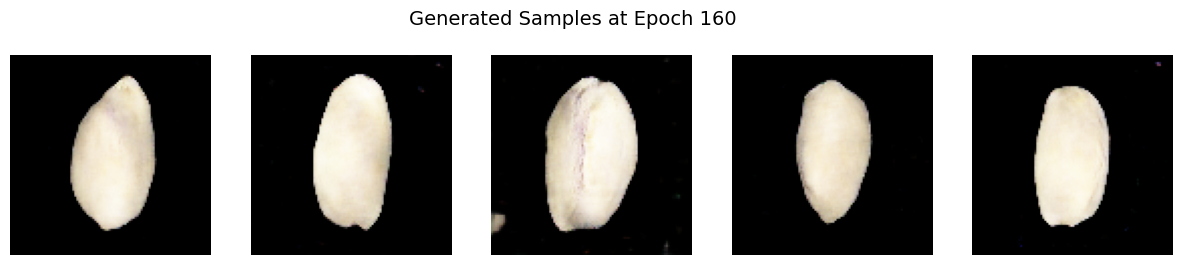

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 1.0308 - gen_loss: 1.3751
Epoch 161/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0344 - gen_loss: 1.3706
Epoch 162/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0520 - gen_loss: 1.4287
Epoch 163/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.0236 - gen_loss: 1.4400
Epoch 164/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.0147 - gen_loss: 1.4999
Epoch 165/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.0364 - gen_loss: 1.4558
Epoch 166/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0145 - gen_loss: 1.4033
Epoch 167/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.0097 - gen_loss: 1.4032
Epoch 168/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9724 - gen_loss: 1.4462
Epoch 169/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0277 - gen_loss: 1.4473
Epoch 170/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_l

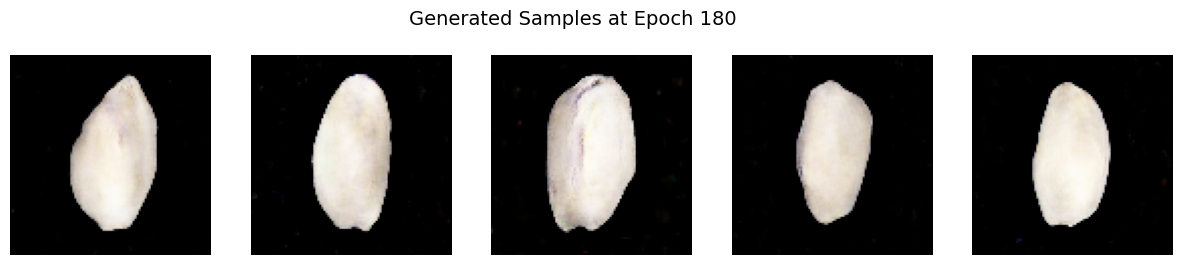

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 1.0044 - gen_loss: 1.5099
Epoch 181/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9748 - gen_loss: 1.4158
Epoch 182/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9948 - gen_loss: 1.5692
Epoch 183/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 1.0007 - gen_loss: 1.5326
Epoch 184/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0172 - gen_loss: 1.4731
Epoch 185/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 1.0210 - gen_loss: 1.5446
Epoch 186/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9955 - gen_loss: 1.5280
Epoch 187/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9786 - gen_loss: 1.5495
Epoch 188/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.9462 - gen_loss: 1.6058
Epoch 189/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9624 - gen_loss: 1.6022
Epoch 190/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - disc_l

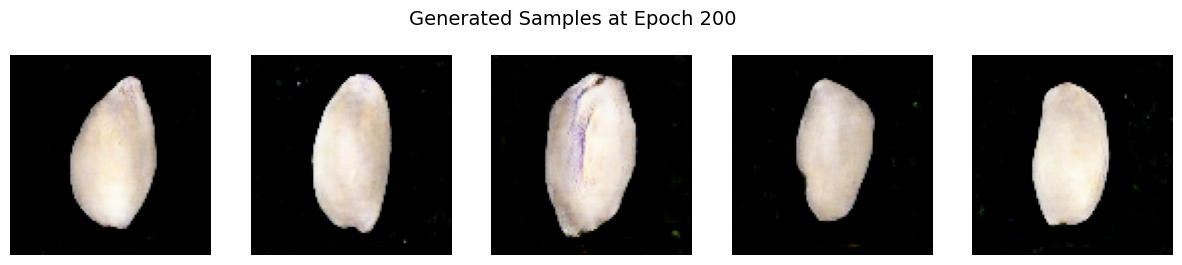

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.9701 - gen_loss: 1.5925
Epoch 201/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9597 - gen_loss: 1.6524
Epoch 202/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9667 - gen_loss: 1.6791
Epoch 203/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9409 - gen_loss: 1.6724
Epoch 204/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9542 - gen_loss: 1.6610
Epoch 205/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.9748 - gen_loss: 1.6541
Epoch 206/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9234 - gen_loss: 1.5708
Epoch 207/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9541 - gen_loss: 1.6630
Epoch 208/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9469 - gen_loss: 1.6570
Epoch 209/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9732 - gen_loss: 1.6259
Epoch 210/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_l

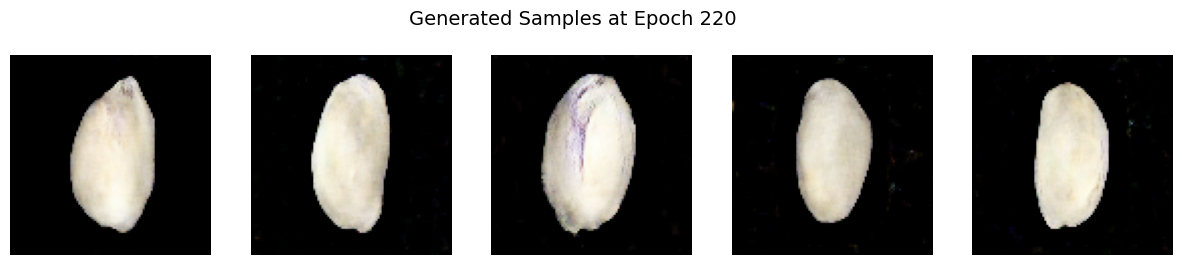

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.9223 - gen_loss: 1.6481
Epoch 221/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9759 - gen_loss: 1.7104
Epoch 222/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9060 - gen_loss: 1.7717
Epoch 223/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9251 - gen_loss: 1.6916
Epoch 224/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9243 - gen_loss: 1.7373
Epoch 225/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9078 - gen_loss: 1.7524
Epoch 226/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.9073 - gen_loss: 1.7537
Epoch 227/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.9015 - gen_loss: 1.8342
Epoch 228/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8840 - gen_loss: 1.7915
Epoch 229/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8921 - gen_loss: 1.8126
Epoch 230/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_l

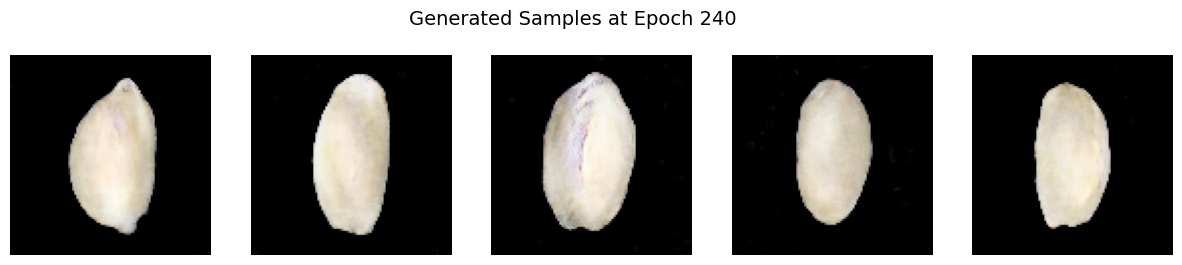

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.9224 - gen_loss: 1.9032
Epoch 241/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.8702 - gen_loss: 1.8108
Epoch 242/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - disc_loss: 0.8900 - gen_loss: 1.8252
Epoch 243/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.8842 - gen_loss: 1.8376
Epoch 244/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.9073 - gen_loss: 1.7844
Epoch 245/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.9088 - gen_loss: 1.8431
Epoch 246/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8846 - gen_loss: 1.8415
Epoch 247/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.8740 - gen_loss: 1.8196
Epoch 248/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8455 - gen_loss: 1.8059
Epoch 249/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.8771 - gen_loss: 1.8795
Epoch 250/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_l

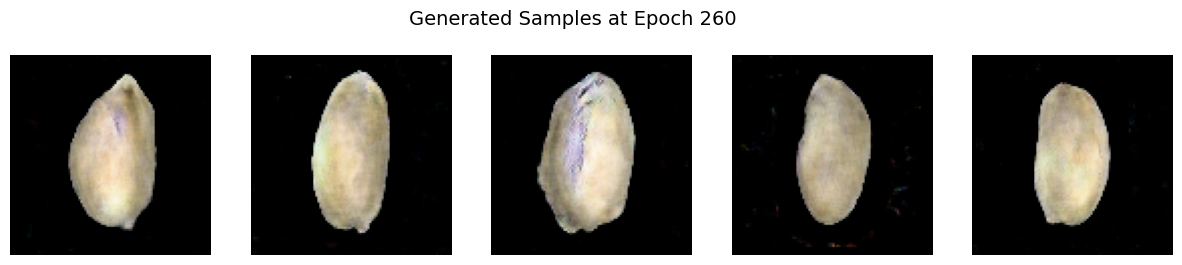

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.8702 - gen_loss: 1.9710
Epoch 261/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.8462 - gen_loss: 1.9781
Epoch 262/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8274 - gen_loss: 1.9046
Epoch 263/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.8506 - gen_loss: 2.0303
Epoch 264/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8382 - gen_loss: 1.9980
Epoch 265/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.8351 - gen_loss: 1.9519
Epoch 266/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.8630 - gen_loss: 1.9441
Epoch 267/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8683 - gen_loss: 1.9618
Epoch 268/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8324 - gen_loss: 1.9965
Epoch 269/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8511 - gen_loss: 1.9937
Epoch 270/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_l

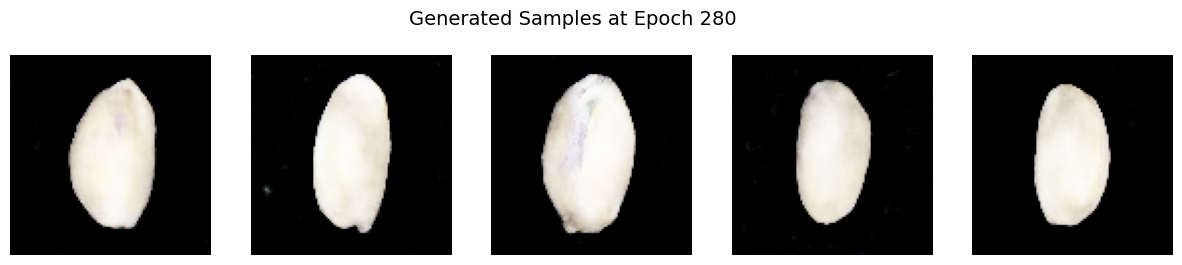

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - disc_loss: 0.8464 - gen_loss: 1.9782
Epoch 281/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.8383 - gen_loss: 2.0177
Epoch 282/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.8355 - gen_loss: 1.9588
Epoch 283/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8110 - gen_loss: 2.0784
Epoch 284/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8311 - gen_loss: 2.1680
Epoch 285/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.8629 - gen_loss: 2.0029
Epoch 286/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.8121 - gen_loss: 2.0584
Epoch 287/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.8238 - gen_loss: 2.0476
Epoch 288/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7646 - gen_loss: 2.1694
Epoch 289/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8501 - gen_loss: 2.0816
Epoch 290/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_l

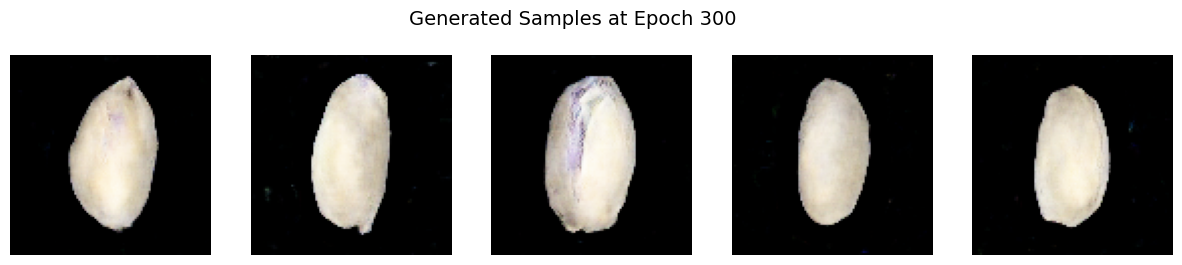

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.8060 - gen_loss: 2.1237
Epoch 301/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7968 - gen_loss: 2.1380
Epoch 302/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.8064 - gen_loss: 2.2344
Epoch 303/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.8078 - gen_loss: 2.2325
Epoch 304/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.8262 - gen_loss: 2.1269
Epoch 305/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - disc_loss: 0.7896 - gen_loss: 2.1562
Epoch 306/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7883 - gen_loss: 2.2024
Epoch 307/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7891 - gen_loss: 2.1656
Epoch 308/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7805 - gen_loss: 2.0671
Epoch 309/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7646 - gen_loss: 2.1332
Epoch 310/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_l

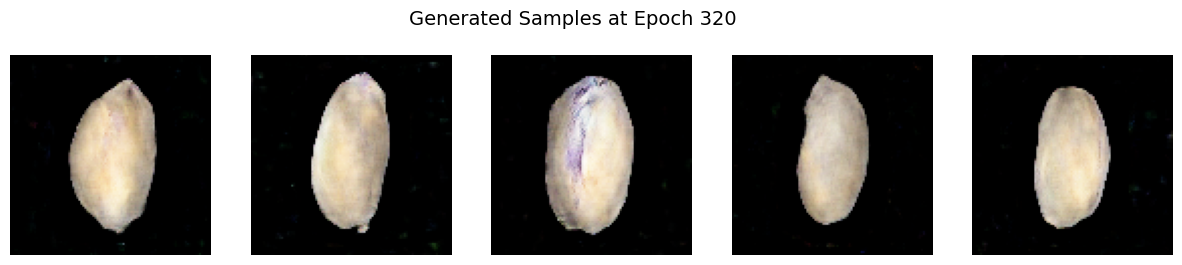

269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - disc_loss: 0.8028 - gen_loss: 2.3317
Epoch 321/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7530 - gen_loss: 2.2647
Epoch 322/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7937 - gen_loss: 2.2406
Epoch 323/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7886 - gen_loss: 2.2758
Epoch 324/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8076 - gen_loss: 2.2981
Epoch 325/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7386 - gen_loss: 2.1973
Epoch 326/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7660 - gen_loss: 2.3451
Epoch 327/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7953 - gen_loss: 2.2538
Epoch 328/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.7726 - gen_loss: 2.3217
Epoch 329/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.8003 - gen_loss: 2.2976
Epoch 330/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_l

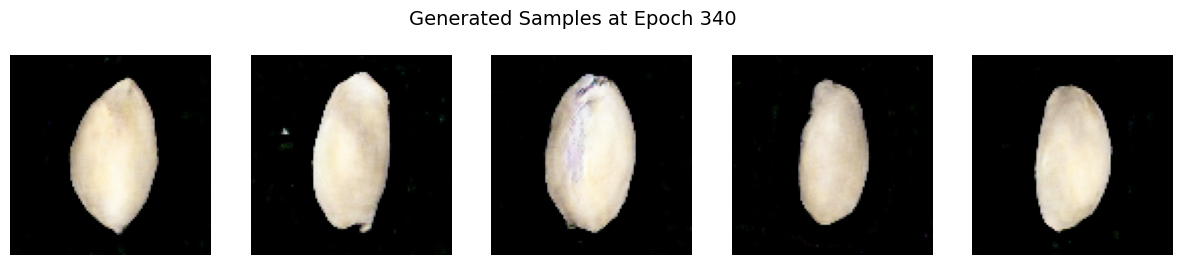

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.7827 - gen_loss: 2.2902
Epoch 341/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7385 - gen_loss: 2.3636
Epoch 342/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7540 - gen_loss: 2.3810
Epoch 343/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7519 - gen_loss: 2.3964
Epoch 344/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7787 - gen_loss: 2.4353
Epoch 345/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7627 - gen_loss: 2.4018
Epoch 346/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7709 - gen_loss: 2.3877
Epoch 347/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.7263 - gen_loss: 2.3739
Epoch 348/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7239 - gen_loss: 2.4024
Epoch 349/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.7664 - gen_loss: 2.3156
Epoch 350/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_l

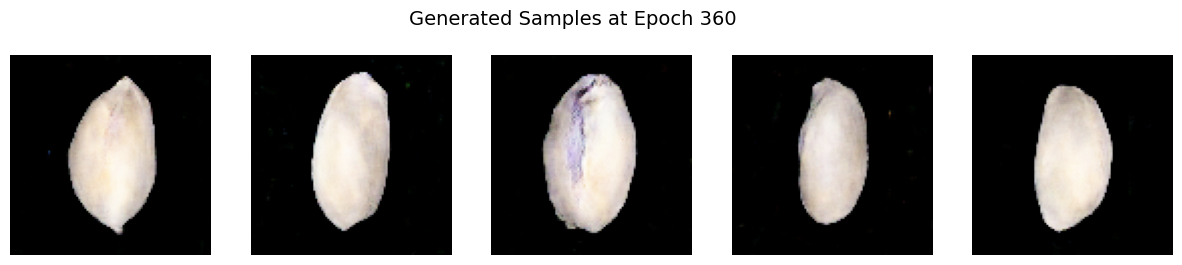

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.7418 - gen_loss: 2.4631
Epoch 361/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7286 - gen_loss: 2.4515
Epoch 362/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7349 - gen_loss: 2.5453
Epoch 363/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7177 - gen_loss: 2.5458
Epoch 364/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7694 - gen_loss: 2.3329
Epoch 365/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7562 - gen_loss: 2.4679
Epoch 366/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7468 - gen_loss: 2.5099
Epoch 367/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7311 - gen_loss: 2.4823
Epoch 368/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7285 - gen_loss: 2.4174
Epoch 369/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7259 - gen_loss: 2.5739
Epoch 370/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_l

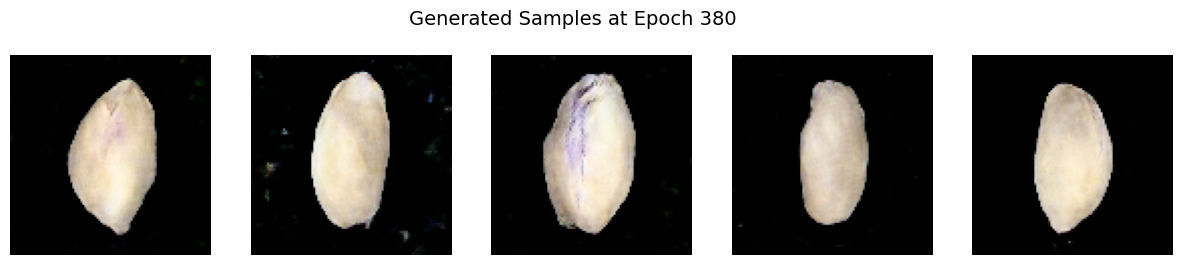

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.6953 - gen_loss: 2.5479
Epoch 381/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.6973 - gen_loss: 2.6128
Epoch 382/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7334 - gen_loss: 2.5811
Epoch 383/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6910 - gen_loss: 2.5567
Epoch 384/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7272 - gen_loss: 2.4757
Epoch 385/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6927 - gen_loss: 2.6285
Epoch 386/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.7377 - gen_loss: 2.6710
Epoch 387/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7143 - gen_loss: 2.6425
Epoch 388/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7124 - gen_loss: 2.5686
Epoch 389/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7077 - gen_loss: 2.5459
Epoch 390/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_l

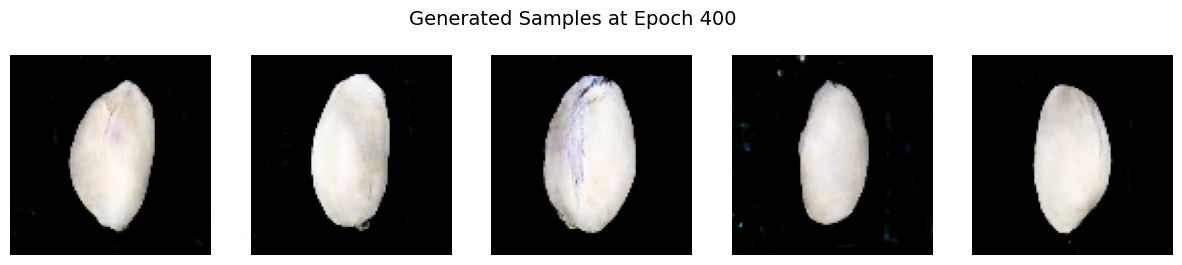

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.6876 - gen_loss: 2.6433
Epoch 401/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7127 - gen_loss: 2.6780
Epoch 402/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7224 - gen_loss: 2.5392
Epoch 403/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7110 - gen_loss: 2.7320
Epoch 404/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7062 - gen_loss: 2.6798
Epoch 405/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.6846 - gen_loss: 2.6965
Epoch 406/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7140 - gen_loss: 2.7292
Epoch 407/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6954 - gen_loss: 2.8087
Epoch 408/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7153 - gen_loss: 2.5559
Epoch 409/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6743 - gen_loss: 2.5455
Epoch 410/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_l

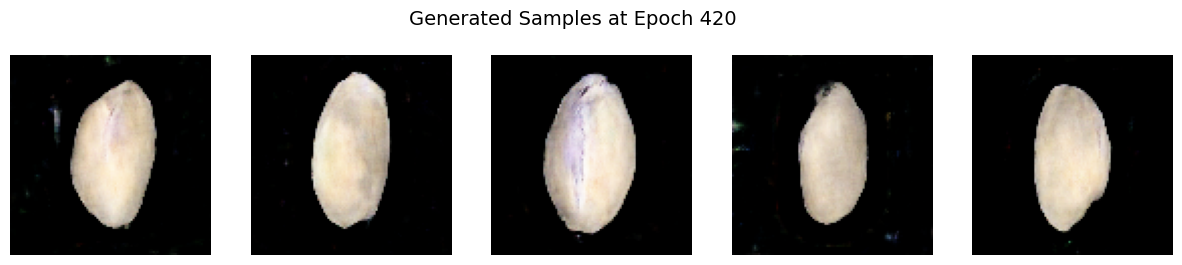

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7173 - gen_loss: 2.5945
Epoch 421/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6985 - gen_loss: 2.7812
Epoch 422/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7406 - gen_loss: 2.7386
Epoch 423/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7202 - gen_loss: 2.5663
Epoch 424/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7196 - gen_loss: 2.7295
Epoch 425/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6872 - gen_loss: 2.8212
Epoch 426/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6766 - gen_loss: 2.6794
Epoch 427/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6917 - gen_loss: 2.8114
Epoch 428/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6676 - gen_loss: 2.6545
Epoch 429/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7069 - gen_loss: 2.7170
Epoch 430/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_l

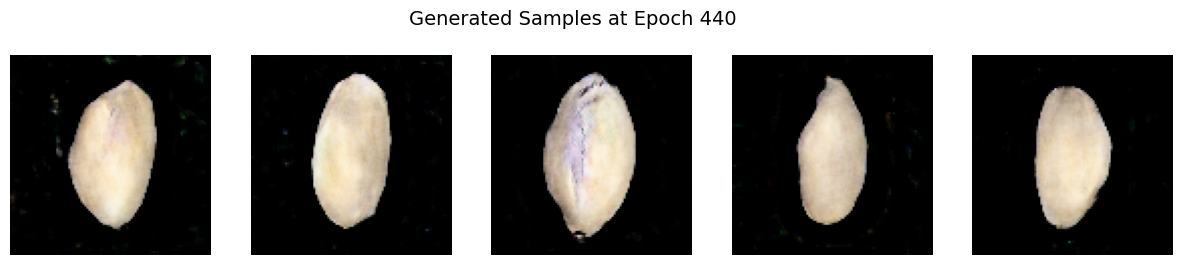

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.6833 - gen_loss: 3.0344
Epoch 441/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6804 - gen_loss: 2.6635
Epoch 442/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7056 - gen_loss: 2.6922
Epoch 443/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.6998 - gen_loss: 2.6815
Epoch 444/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6652 - gen_loss: 2.7620
Epoch 445/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6932 - gen_loss: 2.7608
Epoch 446/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7105 - gen_loss: 2.8226
Epoch 447/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6622 - gen_loss: 2.8593
Epoch 448/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7103 - gen_loss: 2.8881
Epoch 449/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6784 - gen_loss: 2.7911
Epoch 450/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_l

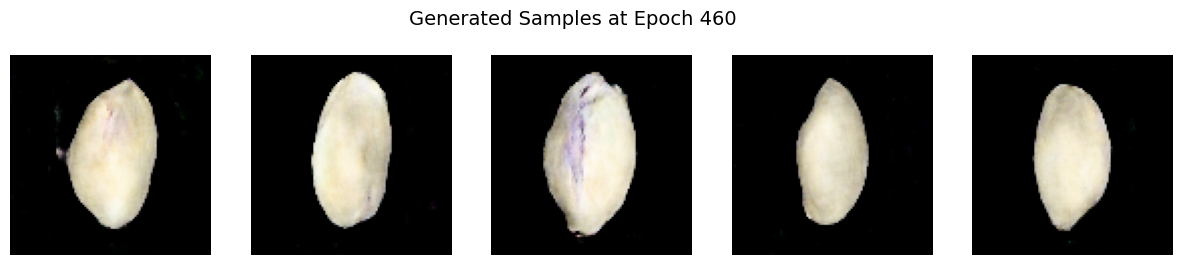

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.7016 - gen_loss: 2.8718
Epoch 461/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.6883 - gen_loss: 2.7853
Epoch 462/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.7114 - gen_loss: 2.7385
Epoch 463/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.6744 - gen_loss: 2.7634
Epoch 464/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.6678 - gen_loss: 2.8734
Epoch 465/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.7011 - gen_loss: 2.8663
Epoch 466/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.6801 - gen_loss: 2.8422
Epoch 467/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6754 - gen_loss: 2.7516
Epoch 468/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.7214 - gen_loss: 2.9187
Epoch 469/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6650 - gen_loss: 2.7442
Epoch 470/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_l

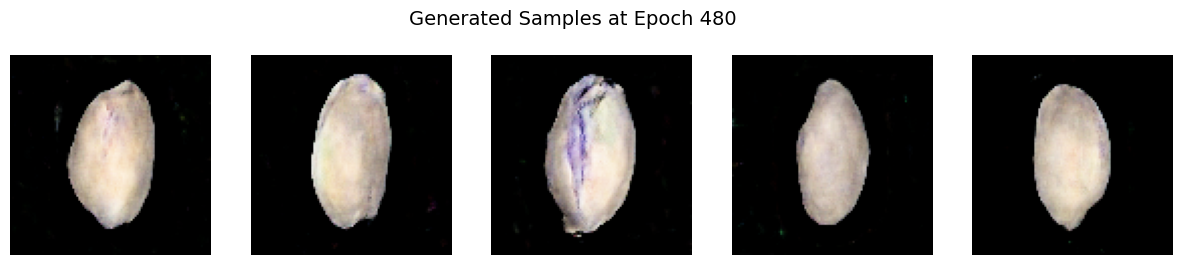

269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - disc_loss: 0.6868 - gen_loss: 2.8974
Epoch 481/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6823 - gen_loss: 3.0530
Epoch 482/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6632 - gen_loss: 2.8083
Epoch 483/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_loss: 0.6443 - gen_loss: 2.8829
Epoch 484/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6504 - gen_loss: 3.0159
Epoch 485/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6679 - gen_loss: 2.7959
Epoch 486/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.7015 - gen_loss: 2.8518
Epoch 487/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6741 - gen_loss: 2.9679
Epoch 488/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - disc_loss: 0.6598 - gen_loss: 2.8785
Epoch 489/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.6770 - gen_loss: 2.8745
Epoch 490/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - disc_l

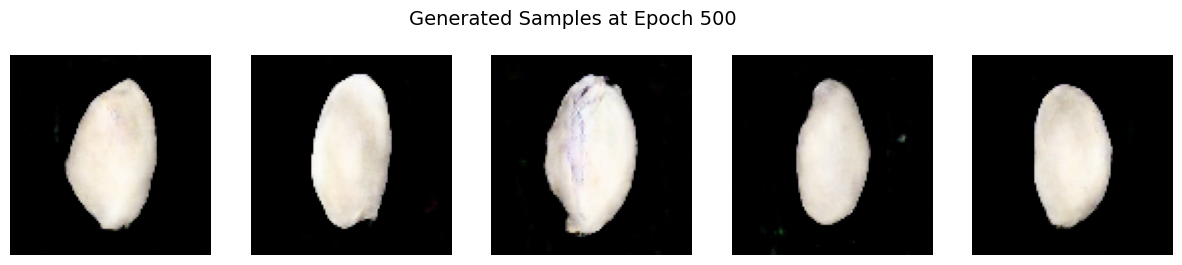

269/269 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - disc_loss: 0.6941 - gen_loss: 3.0256


In [12]:
monitor = GANSnapshotCallback(num_samples=5, latent_dim=noise_dim, save_every=20)

gan.fit(
    real_images,
    epochs=500,
    batch_size=4,
    callbacks=[monitor]
)

## Evaluate Modify Model

In [13]:
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def calculate_fid(model, real_images, fake_images):
    real_resized = np.array([cv2.resize(img, (299, 299)) for img in real_images])
    fake_resized = np.array([cv2.resize(img, (299, 299)) for img in fake_images])

    real_resized = preprocess_input(real_resized.astype(np.float32))
    fake_resized = preprocess_input(fake_resized.astype(np.float32))

    act1 = model.predict(real_resized, batch_size=32, verbose=0)
    act2 = model.predict(fake_resized, batch_size=32, verbose=0)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)

def evaluate_modified_fid(generator, real_images, noise_dim=100, sample_size=1000):
    real_images_sample = real_images[:sample_size].astype(np.float32)
    if real_images_sample.max() > 1.0:
        real_images_sample = real_images_sample / 255.0

    noise = np.random.normal(0, 1, (sample_size, noise_dim))
    gen_imgs = generator.predict(noise, batch_size=32, verbose=0)
    gen_imgs = 0.5 * gen_imgs + 0.5  # [-1,1] → [0,1]

    fid = calculate_fid(inception_model, real_images_sample, gen_imgs)
    print(f"FID Score (Modified Generator): {fid:.2f}")
    return fid

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# call function evaluate
evaluate_modified_fid(generator, real_images)

FID Score (Modified Generator): 105.18


np.float64(105.17558859960631)

Modified 5 revisited Modified 2’s setup, which had shown the best FID, but this time increased the number of epochs to 500 and reduced the batch size to 4. This adjustment was made under the hypothesis that smaller batches might allow for finer gradient updates and more stable training. However, the FID only reached 105—better than Modified 3 and 4, but still not outperforming Modified 2. This implies that while batch size does influence training dynamics, the architecture or overall training strategy might now be the bottleneck.